In [1]:
import datetime as dt
import re
import time

from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from tqdm.notebook import tqdm

In [2]:
BASE_URL = "https://border.gov.md/situatia-la-frontiera-24-de-ore-"

ROMANIAN_MONTHS = {
    1: "ianuarie",
    2: "februarie",
    3: "martie",
    4: "aprilie",
    5: "mai",
    6: "iunie",
    7: "iulie",
    8: "august",
	9: "septembrie",
	10: "octombrie",
	11: "noiembrie",
	12: "decembrie",
}

ROMANIAN_NUMBERS = {
    1: "unu",
    2: "doi",
    3: "trei",
    4: "patru",
    5: "cinci", 
    6: "șase",
    7: "șapte",
    8: "opt",
    9: "nouă",
    10: "zece"
}

HEADERS = {
    "User-Agent":"Mozilla/5.0 (X11; Linux x86_64; rv:60.0) Gecko/20100101 Firefox/60.0",
    "Accept":"text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8"
}

STRINGS_TO_FIND = {
    "all": "fluxul de persoane a constituit (.*?) traversări",
    "foreign": "fost ale cetățenilor străini – (.*?),",
    "air": "alte (.*?) traversări - frontiera aeriană",
    "refusals": "pentru (.*?) persoane s-a aplicat",
    "out": "de ieșire din Republica Moldova – (.*?) traversări",
    "in": "de intrare în Republica Moldova – (.*?) traversări",
}

In [24]:
data_df = pd.read_csv("data.csv", index_col=0)
data_df.index = pd.to_datetime(data_df.index)
start_date = data_df.index.max()+dt.timedelta(days=1)
end_date = dt.datetime.today()

dates_ls = pd.date_range(start_date, end_date)
res_df = pd.DataFrame(index=dates_ls, columns=STRINGS_TO_FIND.keys())
romanian_numbers_rev = {y: x for x, y in ROMANIAN_NUMBERS.items()}
for date in tqdm(dates_ls):
    time.sleep(1)

    url = f"{BASE_URL}{date.day}-{ROMANIAN_MONTHS[date.month]}-{date.year}"
    page = requests.get(url, headers=HEADERS)

    if page.status_code == 404:
        print(f"{url}: page not found")
        continue
    elif page.status_code == 200:
        soup = BeautifulSoup(page.content, "html.parser")
        text = soup.find("div", {"property": "schema:text"}).text
        text = text.replace("\xa0", " ")

        res_s = pd.Series(index=STRINGS_TO_FIND.keys())
        for key, s in STRINGS_TO_FIND.items():
            res = re.findall(s, text)
            if len(res) == 1:
                try:
                    res_proc = int(re.sub("[^0-9]", "", res[0]))
                    res_s[key] = res_proc
                except ValueError:
                    try:
                        res_proc = romanian_numbers_rev[res[0].replace(" ", "")]
                        res_s[key] = res_proc
                    except ValueError:
                        print(f"Can\'t parse {res[0]}")
            else:
                res_s[key] = np.nan
        res_df.loc[date] = res_s
    else:
        print(f"Request returned {page.status_code}")
        break
res_df["in"] = res_df["in"].fillna(res_df["all"] - res_df["out"])
res_df.dropna(how="all", inplace=True)

data_df = pd.concat([data_df, res_df])

data_df.to_csv("data.csv")

  0%|          | 0/2 [00:00<?, ?it/s]

https://border.gov.md/situatia-la-frontiera-24-de-ore-3-septembrie-2023: page not found
https://border.gov.md/situatia-la-frontiera-24-de-ore-4-septembrie-2023: page not found


/var/folders/vp/8mw2q8xn7jv393l4qb_b3rg00000gn/T/ipykernel_84941/4083156849.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_df = pd.concat([data_df, res_df])


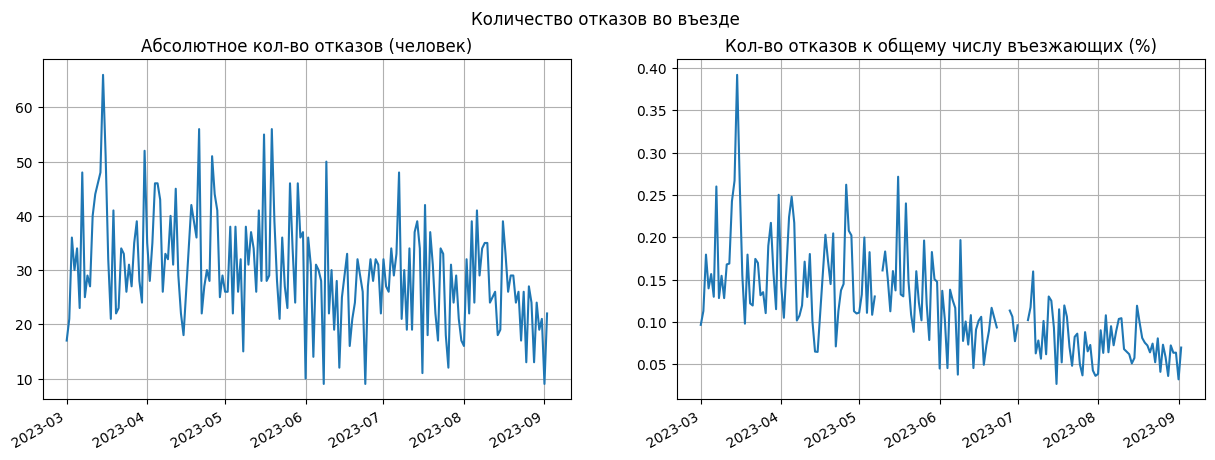

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
data_df["refusals"].plot(ax=axes[0], title="Абсолютное кол-во отказов (человек)", grid=True)
(data_df["refusals"]/data_df["in"]*100).plot(ax=axes[1], title="Кол-во отказов к общему числу въезжающих (%)", grid=True)
plt.suptitle("Количество отказов во въезде")
plt.savefig('images/refusals.png')

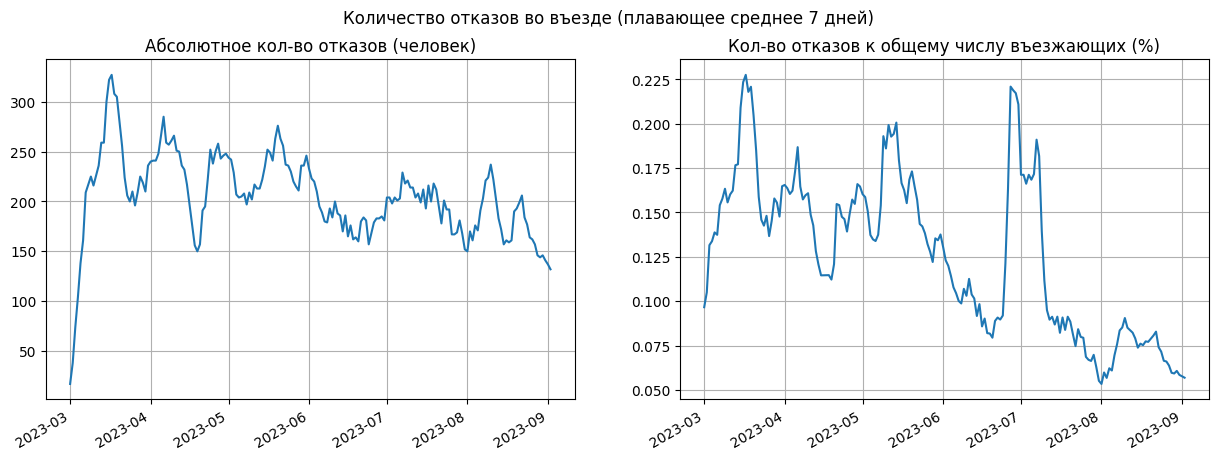

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
data_df["refusals"].rolling("7D").sum().plot(ax=axes[0], title="Абсолютное кол-во отказов (человек)", grid=True)
(data_df["refusals"].rolling("7D").sum()/data_df["in"].rolling("7D").sum()*100).plot(ax=axes[1], title="Кол-во отказов к общему числу въезжающих (%)", grid=True)
plt.suptitle("Количество отказов во въезде (плавающее среднее 7 дней)")
plt.savefig('images/refusals_ma7.png')

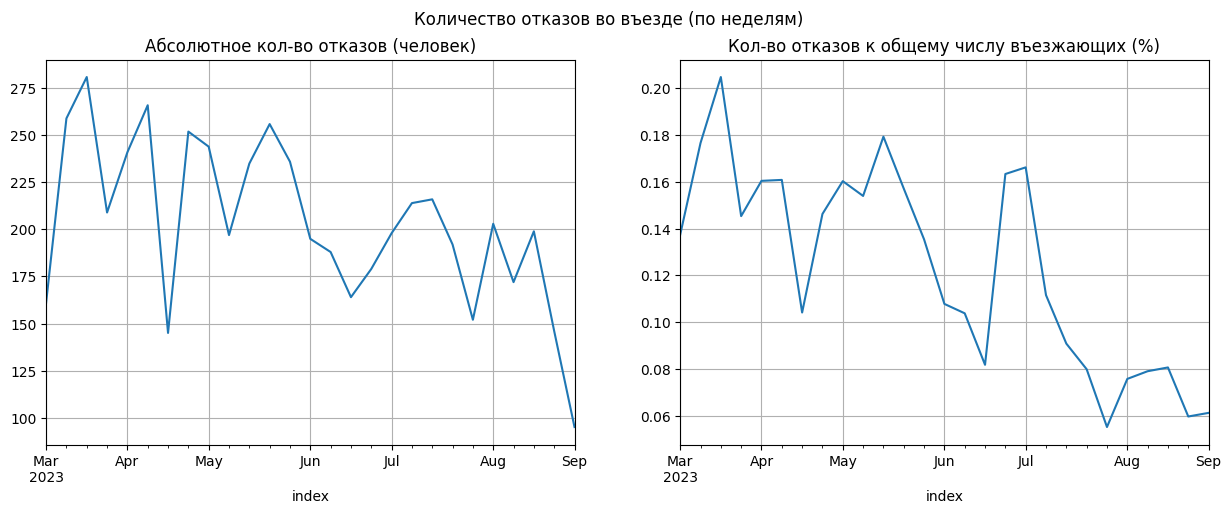

In [27]:
data_w_df = data_df.reset_index().resample('W-Mon', on='index').sum()
data_w_df.loc[data_w_df["in"]==0, "foreign"] = np.nan

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
data_w_df["refusals"].plot(ax=axes[0], title="Абсолютное кол-во отказов (человек)", grid=True)
(data_w_df["refusals"]/data_w_df["in"]*100).plot(ax=axes[1], title="Кол-во отказов к общему числу въезжающих (%)", grid=True)
plt.suptitle("Количество отказов во въезде (по неделям)")
plt.savefig('images/refusals_weeks.png')